In [1]:
import numpy as np # noqa
import pandas as pd
import matplotlib.pyplot as plt # noqa
import tensorflow as tf # noqa
import tensorflow_datasets as tfds
from tqdm.auto import tqdm
import importlib
import gc
import quantus

In [19]:
gc.collect()

3140

In [25]:
importlib.reload(quantus)

<module 'quantus' from '/Users/artemsereda/anaconda3/envs/Quantus-3.9/lib/python3.9/site-packages/quantus-0.1.6-py3.9.egg/quantus/__init__.py'>

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [5]:
# Load datasets
test_ds, ds_info = tfds.load(
    'imagenet_v2',
    split=['test[:5%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=32
)
test_ds = test_ds[0]
test_ds.element_spec

Metal device set to: AMD Radeon Pro 560


(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [6]:
IMG_SIZE = 224
x_batch, y_batch = test_ds.skip(1).take(1).map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)),y)).as_numpy_iterator().next()
x_batch.shape

(32, 224, 224, 3)

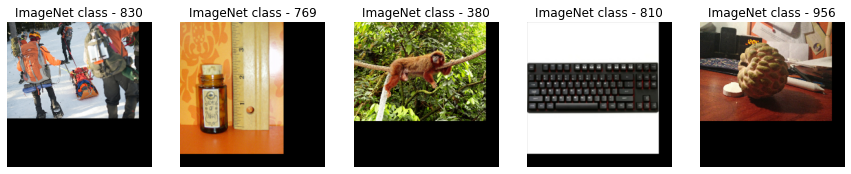

In [7]:
# Plot some inputs!
nr_images = 5

fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))

for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y}")
    axes[i].axis("off")

### 1.2 Load a pre-trained model

In [8]:
model = tf.keras.applications.EfficientNetB0()
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `tf-explain`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [9]:
# Generate Integrated Gradients attributions of the first batch of the test set.
explain_kwargs = {
    'method': 'IntegratedGradients',
}
a_batch = quantus.explain(model, x_batch, y_batch, **explain_kwargs)
a_batch.shape

(32, 224, 224)

Visualise attributions given model and pairs of input-output.

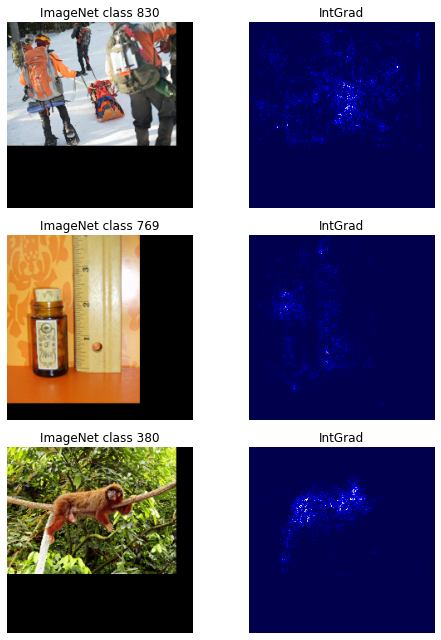

In [10]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(x_batch[i].astype(np.uint8))
    axes[i, 0].title.set_text(f"ImageNet class {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch[i], cmap='seismic')
    axes[i, 1].title.set_text(f"IntGrad")
    axes[i, 1].axis("off")
plt.tight_layout()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [12]:
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "display_progressbar": True,
}


metrics = {"max-Sensitivity": quantus.MaxSensitivity(**params_eval_maxs)}
xai_methods = {"IntegratedGradients": a_batch}

results = quantus.evaluate(
    evaluation_metrics=metrics,
    explanation_methods=xai_methods,
    model=model,
    x_batch=x_batch,
    y_batch=y_batch,
    agg_func=np.mean,
    metrics=metrics,
    xai_methods=xai_methods,
    explain_func=quantus.explain,
    **explain_kwargs
)

pd.DataFrame(results)

Evaluation of MaxSensitivity:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/normalise_func.py:15: RuntimeWarning: invalid value encountered in divide
  return a / a.max()


,IntegratedGradients
max-Sensitivity,0.000023


## [Selectivity](https://arxiv.org/pdf/1706.07979.pdf)

In [ ]:
params_eval_slct = {
    "display_progressbar": True,
    "disable_warnings": True,
    "perturb_func": quantus.random_noise,

}

slct = quantus.Selectivity(**params_eval_slct)
scores_slct = slct(
    model=model,
    x_batch=x_batch,
    y_batch=y_batch,
    a_batch=a_batch.reshape((128, 3, 28, 28)),
)

scores_slct

## [Relative Stability](https://arxiv.org/pdf/2203.06877.pdf)

Let's pre-compute perturbations + explanations to speed it up

In [11]:
xs_batch = []

for _ in tqdm(range(50)):
    xs = quantus.random_noise(x_batch)
    logits = model.predict(xs)
    labels = np.argmax(logits, axis=1)

    same_label_indexes = np.argwhere(labels == y_batch)
    xs = xs[same_label_indexes].reshape(-1, *xs.shape[1:])
    xs_batch.append(xs)

# pull all new images into 0 axes
xs_batch = np.vstack(xs_batch)
# drop images, which cause dims not to be divisible
xs_batch = xs_batch[: xs_batch.shape[0] // x_batch.shape[0] * x_batch.shape[0]]
# make xs_batch have the same shape as x_batch, with new batching axis at 0
xs_batch = xs_batch.reshape(-1, *x_batch.shape)
len(xs_batch)

  0%|          | 0/50 [00:00<?, ?it/s]

37

In [12]:
as_batch = [quantus.explain(model, i, y_batch, **explain_kwargs) for i in tqdm(xs_batch)]

  0%|          | 0/37 [00:00<?, ?it/s]

In [14]:
relative_stability_params = {
    'display_progressbar': True,
    'return_aggregate': True,
}

relative_stability_kwargs = {
    'model': model,
    'x_batch': x_batch,
    'y_batch': y_batch,
    'xs_batch': np.asarray(xs_batch),
    'a_batch': a_batch,
    'as_batch': np.asarray(as_batch)
}

In [16]:
ris = quantus.RelativeInputStability(**relative_stability_params)

ris_result = ris(**relative_stability_kwargs)
ris_result

0.02566693

In [24]:
ros = quantus.RelativeOutputStability(**relative_stability_params)
ros_result = ros(**relative_stability_kwargs)
ros_result

ValueError: cannot reshape array of size 1184000 into shape (37,32,1184,1000)

As relative representation stability leverages explanation change as subject to change in internal representations,
it could be sensitive to choice which ones to take into consideration. So let's try different options out!

In [22]:
rrs = quantus.RelativeRepresentationStability(**relative_stability_params)

rrs_result_1 = rrs(**relative_stability_kwargs)
rrs_result_2 = rrs(**relative_stability_kwargs, layer_names=['test_conv'])
rrs_result_3 = rrs(relative_stability_kwargs, layer_indices=[1, 2, 3])

KeyboardInterrupt: 

In [ ]:
pd.DataFrame([rrs_result_1, rrs_result_2, rrs_result_3], columns=['all layers', 'last conv layers', '1st 3 layers'])